In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import diags, eye, kron, csr_matrix
from scipy.sparse.linalg import spsolve
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
import pickle
import netCDF4 as nc

from scipy.interpolate import griddata
from scipy.optimize import minimize_scalar


In [2]:
def calculate_eddy(width=500e3, num_depth_layers=21, eta0=1, L=1e5, H=1000,
                   a=1, b=1, rho0=1025, f0=None,
                   alpha_1=0.01, alpha_2=0.01,
                   T0=20, dTdz=0.005, dSdz=0.01, taper_depth=None,
                   q11=1.0, q12=0.0, q22=1.0):
    """
    Compute 3D geostrophic U,V and fields for an eddy with prescribed
    quadratic-form shape coefficients q11,q12,q22 (constant in z).
    """
    if f0 is None:
        f0 = 2 * 7.29e-5 * np.sin(np.radians(-34))
    g = 9.81

    x = np.linspace(-width/2, width/2, 51)
    y = np.linspace(-width/2, width/2, 51)
    z = np.linspace(-H, 0, num_depth_layers)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

    taper = np.exp(Z / taper_depth) if taper_depth is not None else 1.0

    # center shift with depth
    Xc = alpha_1 * Z
    Yc = alpha_2 * Z

    # elliptical radius-squared
    dX = X - Xc
    dY = Y - Yc
    r2Q = q11 * dX**2 + 2*q12 * dX * dY + q22 * dY**2

    phi = np.exp(-r2Q / L**2) * taper

    T = -2 * phi
    S = 1.5 * phi
    P = -rho0 * g * Z

    alpha = 2e-4
    beta  = 8e-4
    sigma = rho0 * (1 - alpha*(T - T0) + beta*(S - 35))
    sigma -= sigma.mean()

    dx, dy = x[1]-x[0], y[1]-y[0]
    dsdx = np.gradient(sigma, dx, axis=0)
    dsdy = np.gradient(sigma, dy, axis=1)

    U =  g/f0 * dsdy * taper
    V = -g/f0 * dsdx * taper

    # flip so z=0 is first index
    U, V, sigma, T, S, P = [np.flip(arr, axis=2) for arr in (U,V,sigma,T,S,P)]
    z = z[::-1]

    # transpose horizontal slices
    for k in range(U.shape[2]):
        U[:,:,k] = U[:,:,k].T
        V[:,:,k] = V[:,:,k].T

    return U, V, sigma, T, S, P, x/1000, y/1000, z/1000


In [3]:
def plot_ellipse(Q, center=(0, 0), scale=1):
    # def normalize_matrix(A, norm_type='fro'):
    #     norm = np.linalg.norm(A, 'fro') if norm_type == 'fro' else np.max(np.abs(A))
    #     return A / norm if norm else A
    # Q = normalize_matrix(Q)

    def swap_principal_axes(Q):
        eigvals, eigvecs = np.linalg.eigh(Q)
        return eigvecs @ np.diag(eigvals[::-1]) @ eigvecs.T

    Q = swap_principal_axes(Q)
    
    eigenvalues, eigenvectors = np.linalg.eigh(Q)
    if np.any(eigenvalues < 0):
        Q = np.array([[np.abs(Q[0,0]), Q[0,1]], [Q[1,0], np.abs(Q[1,1])]])

        def flip_Q_y(Q):
            F_y = np.diag([-1, 1])
            return F_y.T @ Q @ F_y

        Q = flip_Q_y(Q)

        eigenvalues, eigenvectors = np.linalg.eigh(Q)
        if np.any(eigenvalues < 0):
            return np.nan, np.nan
            
    a, b = np.sqrt(eigenvalues) * scale
    theta = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    t = np.linspace(0, 2 * np.pi, 100)
    x, y = a * np.cos(t), b * np.sin(t)
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    x_ellipse, y_ellipse = R @ np.array([x, y]) + np.array(center).reshape(2, 1)
    return x_ellipse, y_ellipse

def espra(xi, yi, ui, vi):

    if np.any(np.isnan(ui)):
        return np.nan, np.nan, np.array([[np.nan, np.nan], [np.nan, np.nan]]), np.nan
    
    from scipy.optimize import least_squares

    def residuals(params, x, y, u_i, v_i):
        x0, y0, q11, q12, q22 = params
        u = -2 * q22 * (y - y0) - 2 * q12 * (x - x0)
        v =  2 * q11 * (x - x0) + 2 * q12 * (y - y0)
        return np.concatenate([(u - u_i), (v - v_i)])

    def fit_params(x, y, u_i, v_i):
        x0_init, y0_init = np.mean(x), np.mean(y)
        q11_init, q12_init, q22_init = 1.0, 0.0, 1.0  # Initial guesses
        params_init = [x0_init, y0_init, q11_init, q12_init, q22_init]
        result = least_squares(residuals, params_init, args=(x, y, u_i, v_i))
        return result.x 

    x0, y0, q11, q12, q22 = fit_params(xi, yi, ui, vi)

    w = 2*(q11 + q22)

    Q = np.array([[q11, q12], [q12, q22]])
    
    return x0, y0, w, Q
    

In [4]:
U, V, sigma, T, S, P, x, y, z = calculate_eddy(taper_depth=400)
X, Y, dx = *np.meshgrid(x, y), x[1] - x[0]
dx


np.float64(10.0)

-0.008218620321102665 -2.7973559499494993e-20 -0.008218620321102665


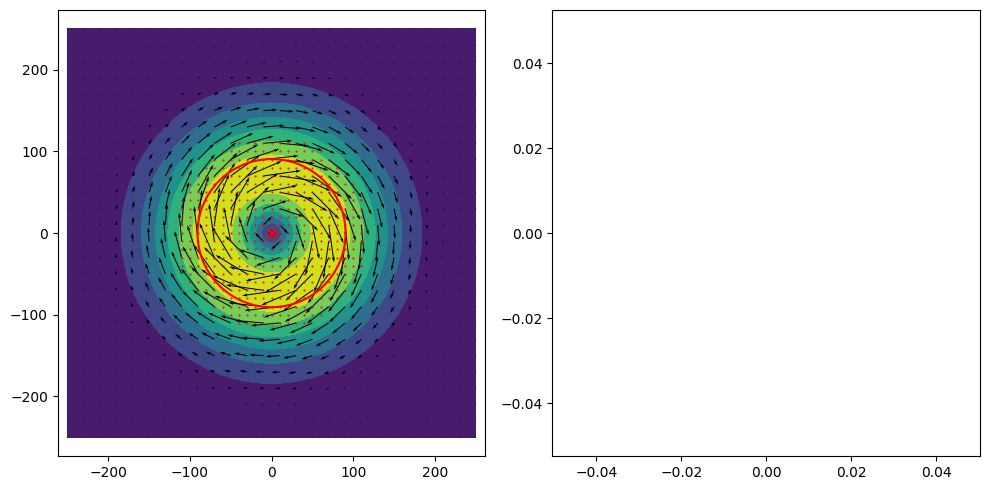

In [5]:
k = 0
u, v = U[:,:,k], V[:,:,k]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].contourf(X, Y, np.hypot(u, v))
spacing = 2
axs[0].quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing], u[::spacing, ::spacing], v[::spacing, ::spacing])
axs[0].axis('equal')

ic, jc, rc = X.shape[0]//2 + 0, X.shape[1]//2 + 0, 120

mask = np.hypot(X-X[ic,jc], Y-Y[ic,jc]) < rc
i, j = np.where(mask)

ui = u.T[i,j]
vi = v.T[i,j]
xi = X.T[i,j]
yi = Y.T[i,j]

x0, y0, w, Q = espra(xi, yi, ui, vi)
q11, q12, q22 = Q[0,0], Q[1,0], Q[1,1]
print(q11, q12, q22)

q11, q12, q22 = np.abs(q11), np.abs(q12), np.abs(q22)

axs[0].scatter(x0, y0, marker='x', color='r')

axs[0].scatter(xi, yi, color='r', marker='.', s=1)


axs[0].scatter(x0, y0, marker='x', color='r', zorder=10)
x_ell, y_ell = plot_ellipse(Q, center=(x0, y0), scale=1000)
axs[0].plot(x_ell, y_ell, 'r')
axs[1].axis('equal')

plt.tight_layout()
plt.show()


## Eddy Velocity Field Retrieval

We define an **elliptical Gaussian eddy** using a streamfunction

$$
\psi(x, y) = \exp\left(-\frac{1}{R^2} \phi(x, y)\right)
$$

where the scalar field $\phi$ is quadratic in $x$ and $y$

$$
\phi(x, y) = q_{11}(x - x_0)^2 + 2q_{12}(x - x_0)(y - y_0) + q_{22}(y - y_0)^2.
$$

This gives an elliptical shape controlled by the symmetric matrix $Q$

$$
Q = \begin{bmatrix}
q_{11} & q_{12} \\
q_{12} & q_{22}
\end{bmatrix}.
$$

The geostrophic velocity field is derived from the streamfunction via

$$
u = -\frac{\partial \psi}{\partial y}, \quad v = \frac{\partial \psi}{\partial x}.
$$

We compute the gradients using the chain rule

$$
\frac{\partial \psi}{\partial x} = -\frac{1}{R^2} \frac{\partial \phi}{\partial x} \exp\left(-\frac{1}{R^2} \phi\right), \quad
\frac{\partial \psi}{\partial y} = -\frac{1}{R^2} \frac{\partial \phi}{\partial y} \exp\left(-\frac{1}{R^2} \phi\right)
$$

with

$$
\frac{\partial \phi}{\partial x} = 2q_{11}(x - x_0) + 2q_{12}(y - y_0),
$$
$$
\frac{\partial \phi}{\partial y} = 2q_{22}(y - y_0) + 2q_{12}(x - x_0).
$$
So the velocity field is 
$$
u = \frac{1}{R^2} \phi_y \exp\left(-\frac{1}{R^2} \phi\right)
$$
$$
v = -\frac{1}{R^2} \phi_x \exp\left(-\frac{1}{R^2} \phi\right)
$$

### Best method

In [6]:
# def fit_Rc(xi, yi, ui, vi, q11, q12, q22, x0, y0):
#     from scipy.optimize import least_squares

#     def residuals(params, x, y, u_i, v_i):
#         Rc, scale = params

#         phi = q11*(x - x0)**2 + 2*q12*(x - x0)*(y - y0) + q22*(y - y0)**2
#         phi_x = 2*q11*(x - x0) + 2*q12*(y - y0)
#         phi_y = 2*q22*(y - y0) + 2*q12*(x - x0)

#         factor = 1 / Rc**2
#         exp_term = np.exp(-factor * phi)

#         u = factor * phi_y * exp_term * scale
#         v = -factor * phi_x * exp_term * scale

#         return np.concatenate([(u - u_i), (v - v_i)])

#     params_init = [10.0, 1.0]
#     bounds_lower = [1.0, 1e-6]     # Rc ≥ 1, scale ≥ tiny positive
#     bounds_upper = [20.0, np.inf] # Rc ≤ 20, scale unbounded above

#     result = least_squares(
#         residuals, params_init,
#         bounds=(bounds_lower, bounds_upper),
#         args=(xi, yi, ui, vi)
#     )
#     Rc_opt, scale_opt = result.x
#     return Rc_opt, scale_opt

# Rc, scale_opt = fit_Rc(xi, yi, ui, vi, q11, q12, q22, x0, y0)
# print(Rc, scale_opt)

def fit_Rc(xi, yi, ui, vi, q11, q12, q22, x0, y0):
    import numpy as np
    from scipy.optimize import least_squares

    q11, q12, q22 = np.abs(q11), np.abs(q12), np.abs(q22)

    def residuals(params, x, y, u_i, v_i):
        Rc, scale = params

        phi = q11*(x - x0)**2 + 2*q12*(x - x0)*(y - y0) + q22*(y - y0)**2
        phi_x = 2*q11*(x - x0) + 2*q12*(y - y0)
        phi_y = 2*q22*(y - y0) + 2*q12*(x - x0)

        factor = 1 / Rc**2
        exp_term = np.exp(-factor * phi)

        u = factor * phi_y * exp_term * scale
        v = -factor * phi_x * exp_term * scale

        return np.concatenate([(u - u_i), (v - v_i)])

    # Initial guesses: Rc=10, scale=1
    params_init = [1.0, 1.0]
    bounds_lower = [1e-6, -np.inf]   # Rc ≥ 1, scale ≥ 0.01
    bounds_upper = [20.0, np.inf] # Rc ≤ 20, scale ≤ 100

    result = least_squares(residuals, params_init, bounds=(bounds_lower, bounds_upper), args=(xi, yi, ui, vi))
    Rc_opt, scale_opt = result.x
    return Rc_opt, scale_opt

Rc, scale_opt = fit_Rc(xi, yi, ui, vi, q11, q12, q22, x0, y0)
print(Rc, scale_opt)



7.445082853462145 50.35822631242306


#### Reconstruct

In [7]:
def gaussian_vel_reconstruction(x0, y0, q11, q12, q22, R):

    q11, q12, q22 = np.abs(q11), np.abs(q12), np.abs(q22)
    
    width = 200
    x = np.linspace(x0-width, x0+width, 51)
    y = np.linspace(y0-width, y0+width, 51)
    X, Y = np.meshgrid(x, y)
    
    dx, dy = X - x0, Y - y0
    
    phi   = q11*dx**2 + 2*q12*dx*dy + q22*dy**2
    phi_x = 2*q11*dx  + 2*q12*dy
    phi_y = 2*q22*dy  + 2*q12*dx
    
    # 5) build Gaussian streamfunction with that R
    exp_term = np.exp(-phi / R**2)
    psi_x = -phi_x / R**2 * exp_term
    psi_y = -phi_y / R**2 * exp_term
    
    u = -psi_y 
    v =  psi_x 

    return u, v, X, Y

u_new, v_new, X_new, Y_new = gaussian_vel_reconstruction(x0, y0, q11, q12, q22, Rc)
u_new *= scale_opt
v_new *= scale_opt



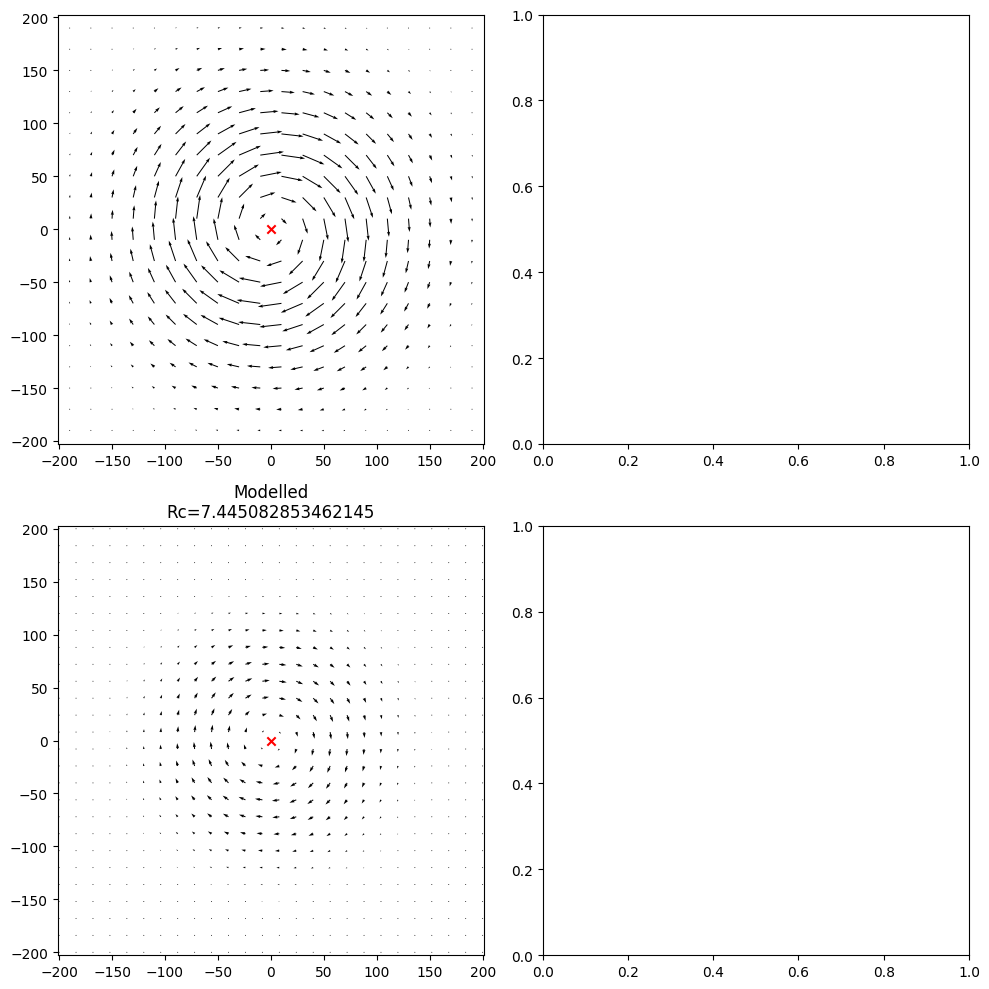

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
quiv_scale = 30

spacing = 2
axs[0,0].quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing],
           u[::spacing, ::spacing], v[::spacing, ::spacing], scale=quiv_scale)
axs[0,0].scatter(x0, y0, marker='x', color='r')

# axs[0,0].plot(x1, y1, color='r', linewidth=2, zorder=1)
# axs[0,0].plot(x2, y2, color='r', linewidth=2, zorder=1)

axs[0,0].axis('equal')
axs[0,0].set_xlim(-200, 200)
axs[0,0].set_ylim(-200, 200)

# axs[0,1].plot(xx, u1, label=r'$u_1$')
# axs[0,1].plot(xx, v1, label=r'$v_1$')
# axs[0,1].plot(yy, u2, label=r'$u_2$')
# axs[0,1].plot(yy, v2, label=r'$v_2$')
# axs[0,1].legend()

# axs[1,0].pcolor(X_new, Y_new, np.hypot(u_new, v_new))
# axs[1,0].colorbar()
spacing = 2
axs[1,0].quiver(X_new[::spacing, ::spacing], Y_new[::spacing, ::spacing],
           u_new[::spacing, ::spacing], v_new[::spacing, ::spacing], scale=quiv_scale)

# axs[1,0].plot(x1, y1, color='r', linewidth=2, zorder=1)
# axs[1,0].plot(x2, y2, color='r', linewidth=2, zorder=1)
axs[1,0].scatter(x0, y0, marker='x', color='r')
axs[1,0].set_title(f'Modelled\nRc={Rc}')

axs[1,0].axis('equal')
axs[1,0].set_xlim(-200, 200)
axs[1,0].set_ylim(-200, 200)

# axs[1,1].plot(xx, u1_psi, label=r'$u_1$')
# axs[1,1].plot(xx, v1_psi, label=r'$v_1$')
# axs[1,1].plot(yy, u2_psi, label=r'$u_2$')
# axs[1,1].plot(yy, v2_psi, label=r'$v_2$')
# axs[1,1].legend()

plt.tight_layout()
plt.show()


## ROMS

In [9]:
fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

with open('/srv/scratch/z5297792/Chapter2/dic_sample.pkl', 'rb') as f:
    dic_sample = pickle.load(f)
sample_eddies = list(dic_sample.keys())

df_eddies = pd.read_pickle("/srv/scratch/z5297792/Chapter2/df_eddies_meso.pkl")


In [10]:
sample_eddies

['Eddy2749',
 'Eddy8',
 'Eddy2504',
 'Eddy896',
 'Eddy1394',
 'Eddy382',
 'Eddy1967',
 'Eddy926']

In [11]:
eddy = sample_eddies[7]
dic = dic_sample[eddy]
day = list(dic.keys())[10]
df_snapshot = dic[day]

fname = df_eddies[(df_eddies['ID']==int(eddy[4:]))&(df_eddies['Day']==int(day[3:]))].iloc[0]['fname']
fnumber = fname[-8:-3]
u_raw = np.load(f'/srv/scratch/z5297792/Climatology/u_v/u_{fnumber}.npy')
v_raw = np.load(f'/srv/scratch/z5297792/Climatology/u_v/v_{fnumber}.npy')
u_raw = np.where(u_raw > 1e30, np.nan, u_raw).astype(float)
v_raw = np.where(v_raw > 1e30, np.nan, v_raw).astype(float)
with nc.Dataset(fname) as dataset:
    ocean_time = dataset.variables['ocean_time'][:].data / 86400
t_rel = np.where(ocean_time == int(day[3:]))[0][0]

k = 0
data = df_snapshot.iloc[k]
x0, y0, Q, w, depth = data.x, data.y, data.Q, data.w, data.Depth
q11, q12, q22 = Q[0,0], Q[1,0], Q[1,1]
print(q11, q12, q22)

u, v = u_raw[:, :, k, t_rel], v_raw[:, :, k, t_rel]
u = np.where(mask_rho, u, np.nan)
v = np.where(mask_rho, v, np.nan)

# Extract Eddy Domain
mask = np.hypot(X_grid - x0, Y_grid - y0) <= 200
i_mask, j_mask = np.where(mask)
i_mask = np.arange(i_mask.min(), i_mask.max() + 1)
j_mask = np.arange(j_mask.min(), j_mask.max() + 1)
i_mask, j_mask = np.meshgrid(i_mask, j_mask)
i_mask, j_mask = i_mask.flatten(), j_mask.flatten()

i_min, j_min = i_mask.min(), j_mask.min()
i_range, j_range = i_mask.max() - i_min + 1, j_mask.max() - j_min + 1

u_eddy_domain = np.zeros((i_range, j_range))
v_eddy_domain = np.zeros((i_range, j_range))
X_eddy_domain = np.zeros((i_range, j_range))
Y_eddy_domain = np.zeros((i_range, j_range))
x_eddy_domain, y_eddy_domain = X_eddy_domain[:,0], Y_eddy_domain[0,:]

for i, j in zip(i_mask, j_mask):
    u_eddy_domain[i - i_min, j - j_min] = u[i, j]
    v_eddy_domain[i - i_min, j - j_min] = v[i, j]
    X_eddy_domain[i - i_min, j - j_min] = X_grid[i, j]
    Y_eddy_domain[i - i_min, j - j_min] = Y_grid[i, j]


-0.01077415172100438 -0.0035268849476641447 -0.016870360300531306


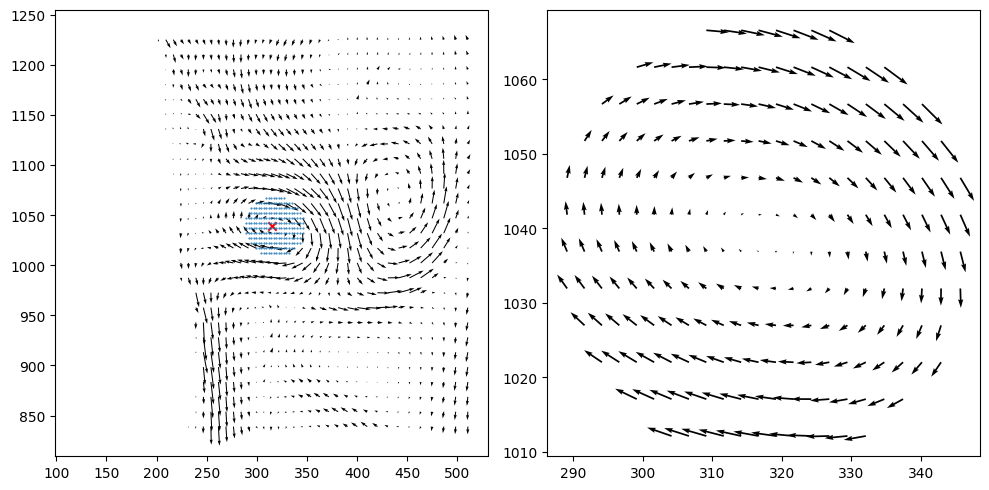

In [12]:
r = 30
mask = np.hypot(X_eddy_domain - x0, Y_eddy_domain - y0).T < r
i, j = np.where(mask)

ui = u_eddy_domain.T[i,j]
vi = v_eddy_domain.T[i,j]
xi = X_eddy_domain.T[i,j]
yi = Y_eddy_domain.T[i,j]

x0, y0, w, Q = espra(xi, yi, ui, vi)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

spacing = 3
axs[0].quiver(X_eddy_domain[::spacing, ::spacing], Y_eddy_domain[::spacing, ::spacing],
           u_eddy_domain[::spacing, ::spacing], v_eddy_domain[::spacing, ::spacing])
axs[0].scatter(x0, y0, marker='x', color='r')
axs[0].axis('equal')

axs[0].scatter(xi, yi, marker='.', s=1)

axs[1].quiver(xi, yi, ui, vi)

plt.tight_layout()
plt.show()


In [13]:
Rc, scale_opt = fit_Rc(xi, yi, ui, vi, q11, q12, q22, x0, y0)
print("Optimal Rc =", Rc)
print("Optimal Scale =", scale_opt)


Optimal Rc = 11.005647207725602
Optimal Scale = 118.74350768479994


In [14]:
u, v, X, Y = gaussian_vel_reconstruction(x0, y0, q11, q12, q22, Rc)
u *= scale_opt
v *= scale_opt

In [15]:
X_eddy_domain[1,0]-X_eddy_domain[0,0]

np.float64(2.622214000347384)

In [16]:
X[0,1]-X[0,0]

np.float64(8.0)

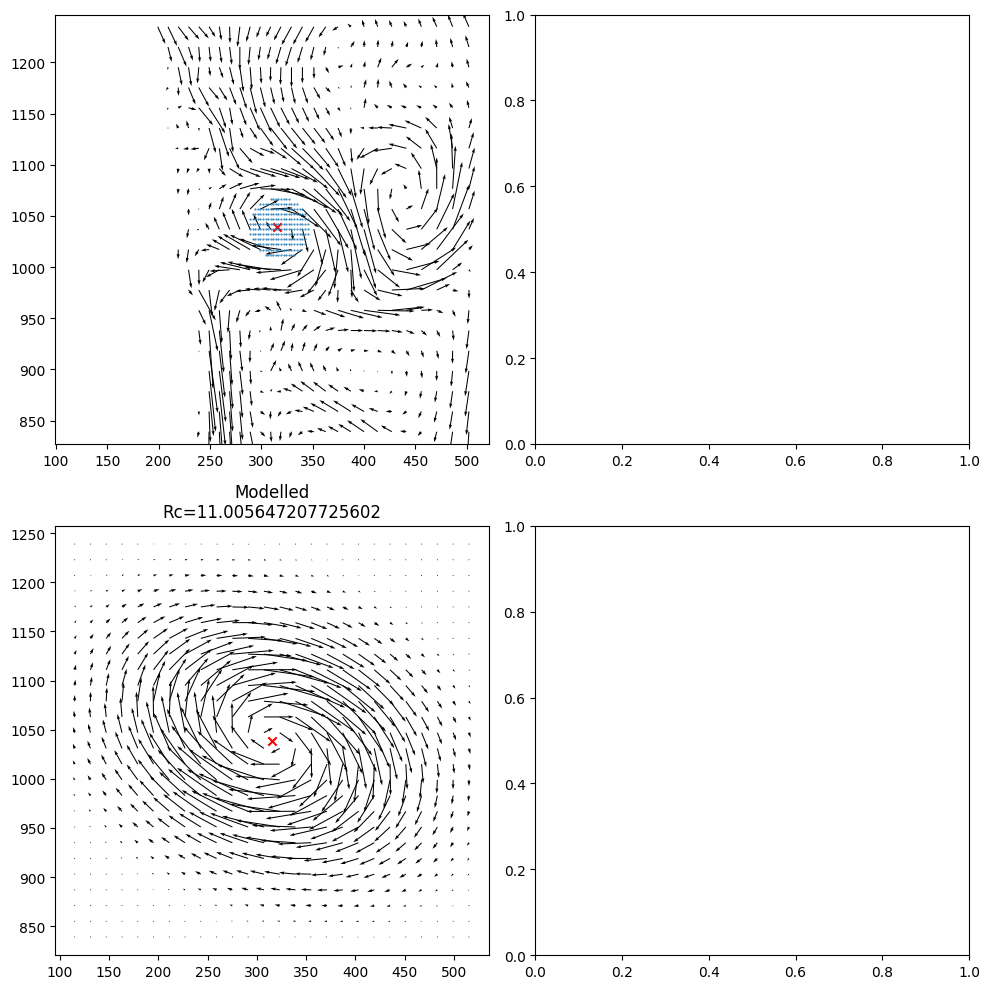

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
quiv_scale = 10

spacing = 4
axs[0,0].quiver(X_eddy_domain[::spacing, ::spacing], Y_eddy_domain[::spacing, ::spacing],
           u_eddy_domain[::spacing, ::spacing], v_eddy_domain[::spacing, ::spacing], scale=quiv_scale)
axs[0,0].scatter(x0, y0, marker='x', color='r')
axs[0,0].axis('equal')

axs[0,0].scatter(xi, yi, marker='.', s=1)



# axs[1,0].pcolor(X, Y, np.hypot(u, v))
# axs[1,0].colorbar()
spacing = 2
axs[1,0].quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing],
           u[::spacing, ::spacing], v[::spacing, ::spacing], scale=quiv_scale)
axs[1,0].axis('equal')

axs[1,0].scatter(x0, y0, marker='x', color='r')
axs[1,0].set_title(f'Modelled\nRc={Rc}')


plt.tight_layout()
plt.show()
